In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
from tqdm import tqdm
import pandas as pd
import h5py

from explainability_utils import *

# Add the 'training' directory to sys.path
sys.path.append(os.path.abspath("../training"))
from training_utils import CNN2D, ExplainerDataset, SpectraDataset
plt.rcParams.update({'font.size': 18})

c:\Users\miche\OneDrive\Desktop\EQML Project\CNN-Explainability-on-Earthquakes\CNN_EQML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42
Seed set to 42


(../preprocessed_dset/spectrograms) Mean: [0.68137387 0.66712049 0.64939852], Std: [0.13272135 0.1345285  0.13304515] (calculated and saved)


In [2]:
# Path to the data
base_path = "..\preprocessed_dset"
data_path = os.path.join(base_path, "spectrograms")
meta_path = os.path.join(base_path, "metadata.csv")
wave_path = r"..\dset\data\catalogs\NRCA"

shap_data_path = 'samples'

output_path = "shap_tensors"
os.makedirs(output_path, exist_ok=True)
MAX_EVALS = 5000


f_t_range_64_path = os.path.join(data_path, "f_t_range.npy")
tf = np.load(f_t_range_64_path)

ft = [tf[:2], tf[2:]]

# Path to the best model found in the training notebooks
best_model_path = r"..\training\model_checkpoints\best_model_fold_2.ckpt"
best_model_c_path = r"..\training\model_checkpoints\best_model_c_fold_2.ckpt"

sample_dim = (33, 96)

# Setting for the datasets
mean, std = spectra_stats(data_path, meta_path)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN2D.load_from_checkpoint(best_model_path, input_dim=sample_dim, num_classes=2)
model.eval()
model.to(device)
print("Model loaded")

(..\preprocessed_dset\spectrograms) Mean: [0.68137387 0.66712049 0.64939852], Std: [0.13272135 0.1345285  0.13304515] (calculated and saved)
Using device: cuda
Model loaded


### Compute SHAP Tensor for each explainability set sample

#### Foreshocks

In [19]:
dset_pre = ExplainerDataset(data_path = os.path.join(shap_data_path, 'foreshocks'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_pre = DataLoader(dset_pre, batch_size=1, shuffle=False)

In [ ]:
output_dir = os.path.join(output_path, "foreshocks")
os.makedirs(output_dir, exist_ok=True)
for sample in tqdm(dloader_pre, total = 300):
    compute_shap_tensor(model = model,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = output_dir)

In [9]:
# Compute mean SHAP Tensor (P-fixed)

output_dir = os.path.join(output_path, "foreshocks")
p_mean_pre = np.zeros((*sample_dim, 3)) # shape (33, 96, 3)
tot = 300

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        shap = np.load(file_path) # shape (1, 33, 96, 3)
        shap = shap.squeeze(axis=0) # shape (33, 96, 3)
        p_mean_pre += shap/tot

np.save(os.path.join(output_path, "avg_p_pre.npy"), p_mean_pre)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_p_pre.npy')} \nShape: {p_mean_pre.shape}")

100%|██████████| 300/300 [00:00<00:00, 1072.83it/s]

Tensor saved at: shap_tensors\avg_p_pre.npy 
Shape: (33, 96, 3)


In [10]:
# Compute mean SHAP Tensor (S-fixed)

output_dir = os.path.join(output_path, "foreshocks")
df = pd.read_csv(meta_path)
tot = 300
pixel_per_sec = sample_dim[1]/13
duration = int(8*pixel_per_sec)
s_mean_pre = np.zeros((sample_dim[0], duration, 3)) # shape (33, 59, 3)

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        trace_name = filename.removesuffix(".npy")
        shap = np.load(file_path).squeeze(axis=0) # shape (33, 96, 3)
        p_s_diff_sec = df[df["trace_name"]==trace_name]["p_s_diff_sec"].values[0]

        s_arrival = 5 + p_s_diff_sec
        start = s_arrival - 4
        start_pixel = int(start * pixel_per_sec)
        shap = shap[:,start_pixel:start_pixel+duration,:]

        s_mean_pre += shap/tot

np.save(os.path.join(output_path, "avg_s_pre.npy"), s_mean_pre)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_s_pre.npy')} \nShape: {s_mean_pre.shape}")

100%|██████████| 300/300 [00:00<00:00, 341.36it/s]

Tensor saved at: shap_tensors\avg_s_pre.npy 
Shape: (33, 59, 3)


#### Aftershocks

In [20]:
dset_post = ExplainerDataset(data_path = os.path.join(shap_data_path, 'aftershocks'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_post = DataLoader(dset_post, batch_size=1, shuffle=False)

In [ ]:
output_dir = os.path.join(output_path, "aftershocks")
os.makedirs(output_dir, exist_ok=True)
for sample in tqdm(dloader_post, total = 300):
    compute_shap_tensor(model = model,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = output_dir)

In [22]:
# Compute mean SHAP Tensor (P-fixed)

output_dir = os.path.join(output_path, "aftershocks")
p_mean_post = np.zeros((*sample_dim, 3)) # shape (33, 96, 3)
tot = 300

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        shap = np.load(file_path) # shape (1, 33, 96, 3)
        shap = shap.squeeze(axis=0) # shape (33, 96, 3)
        p_mean_post += shap/tot

np.save(os.path.join(output_path, "avg_p_post.npy"), p_mean_post)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_p_post.npy')} \nShape: {p_mean_post.shape}")

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 844.71it/s]

Tensor saved at: shap_tensors\avg_p_post.npy 
Shape: (33, 96, 3)


In [23]:
# Compute mean SHAP Tensor (S-fixed)

output_dir = os.path.join(output_path, "aftershocks")
df = pd.read_csv(meta_path)
tot = 300
pixel_per_sec = sample_dim[1]/13
duration = int(8*pixel_per_sec)
s_mean_post = np.zeros((sample_dim[0], duration, 3)) # shape (33, 59, 3)

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        trace_name = filename.removesuffix(".npy")
        shap = np.load(file_path).squeeze(axis=0) # shape (33, 96, 3)
        p_s_diff_sec = df[df["trace_name"]==trace_name]["p_s_diff_sec"].values[0]

        s_arrival = 5 + p_s_diff_sec
        start = s_arrival - 4
        start_pixel = int(start * pixel_per_sec)
        shap = shap[:,start_pixel:start_pixel+duration,:]

        s_mean_post += shap/tot

np.save(os.path.join(output_path, "avg_s_post.npy"), s_mean_post)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_s_post.npy')} \nShape: {s_mean_post.shape}")

100%|██████████| 300/300 [00:00<00:00, 355.94it/s]

Tensor saved at: shap_tensors\avg_s_post.npy 
Shape: (33, 59, 3)


#### Misclassified

In [6]:
# COMPUTE SHAP FOR MISCLASSIFIED TRACES
target_shap_folder = os.path.join(output_path, "misclassified")
os.makedirs(target_shap_folder, exist_ok=True)

dset_m = ExplainerDataset(data_path = os.path.join(shap_data_path, 'misclassified'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_m = DataLoader(dset_m, batch_size=1, shuffle=False)

for sample in tqdm(dloader_m):
    compute_shap_tensor(model = model,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = target_shap_folder,
                        len_label_channels_shap=2)

PartitionExplainer explainer: 2it [00:42, 42.16s/it]               
PartitionExplainer explainer: 2it [00:32, 32.12s/it]               
PartitionExplainer explainer: 2it [00:36, 36.42s/it]               
PartitionExplainer explainer: 2it [00:33, 33.05s/it]               
100%|██████████| 4/4 [02:39<00:00, 39.90s/it]


In [7]:
print("Shape SHAP Tensor: ", np.load(os.path.join(target_shap_folder, os.listdir(target_shap_folder)[0])).shape)
print("Total computed traces: ", len(os.listdir(target_shap_folder)))

Shape SHAP Tensor:  (1, 33, 96, 3, 2)
Total computed traces:  4


#### Single Examples

In [6]:
# COMPUTE SHAP FOR MISCLASSIFIED TRACES
target_shap_folder = os.path.join(output_path, "examples")
os.makedirs(target_shap_folder, exist_ok=True)

dset_s = ExplainerDataset(data_path = os.path.join(shap_data_path, 'examples'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_s = DataLoader(dset_s, batch_size=1, shuffle=False)

for sample in tqdm(dloader_s):
    compute_shap_tensor(model = model,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = target_shap_folder,
                        len_label_channels_shap=2)

PartitionExplainer explainer: 2it [00:30, 30.20s/it]               
PartitionExplainer explainer: 2it [00:35, 35.95s/it]               
100%|██████████| 2/2 [01:06<00:00, 33.17s/it]


In [4]:
print("Shape SHAP Tensor: ", np.load(os.path.join(target_shap_folder, os.listdir(target_shap_folder)[0])).shape)
print("Total computed traces: ", len(os.listdir(target_shap_folder)))

Shape SHAP Tensor:  (1, 33, 96, 3, 2)
Total computed traces:  2


### Plots

In [4]:
df = pd.read_csv(meta_path)

foreshock_traces = []
for filename in os.listdir(os.path.join(output_path, "foreshocks")):
    if filename.endswith(".npy"):
        foreshock_traces.append(filename.removesuffix(".npy"))

foreshock_df = df[df["trace_name"].isin(foreshock_traces)]
foreshock_s_diff = foreshock_df[foreshock_df["p_s_diff_sec"] >= 0]["p_s_diff_sec"].values
print("Foreshock entries: ", len(foreshock_df))

aftershock_traces = []
for filename in os.listdir(os.path.join(output_path, "aftershocks")):
    if filename.endswith(".npy"):
        aftershock_traces.append(filename.removesuffix(".npy"))

aftershock_df = df[df["trace_name"].isin(aftershock_traces)]
aftershock_s_diff = aftershock_df[aftershock_df["p_s_diff_sec"] >= 0]["p_s_diff_sec"].values
print("Aftershock entries: ", len(aftershock_df))

Foreshock entries:  300
Aftershock entries:  300


#### Average P-fixed

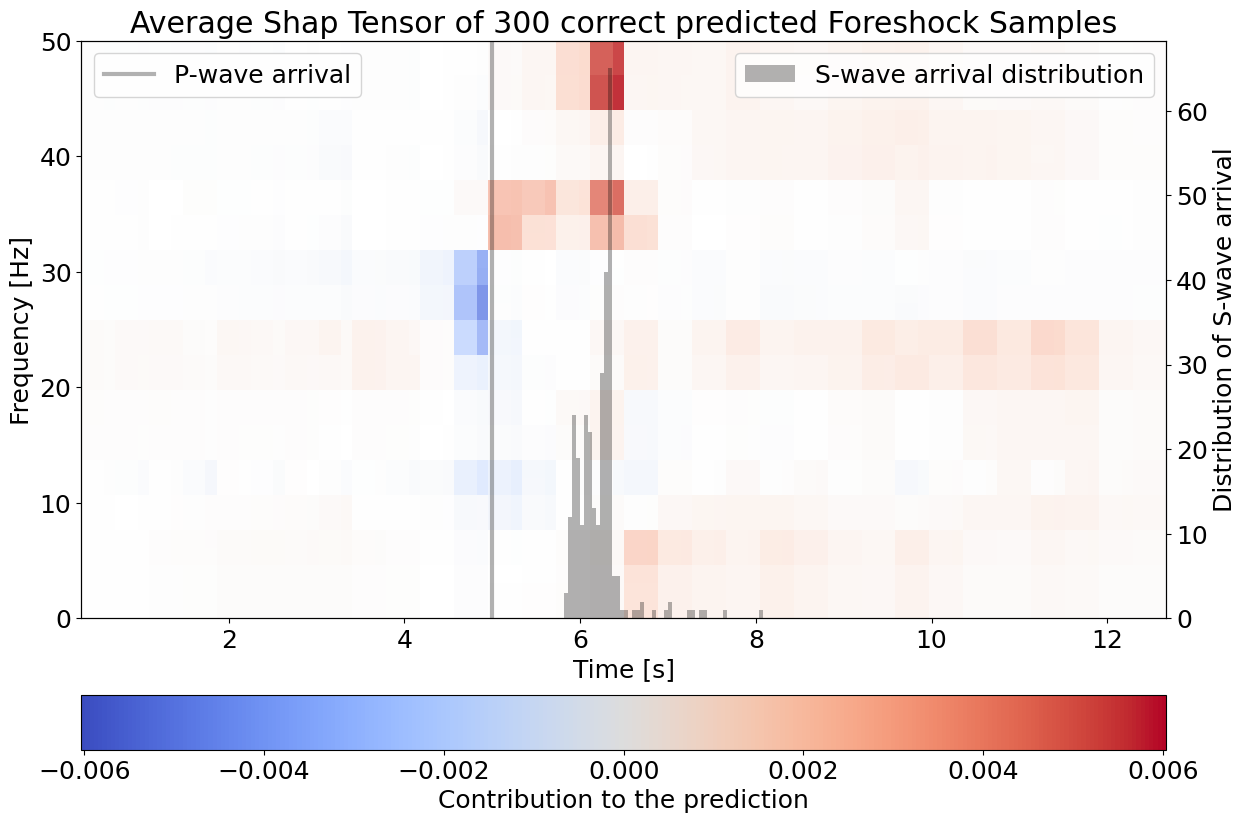

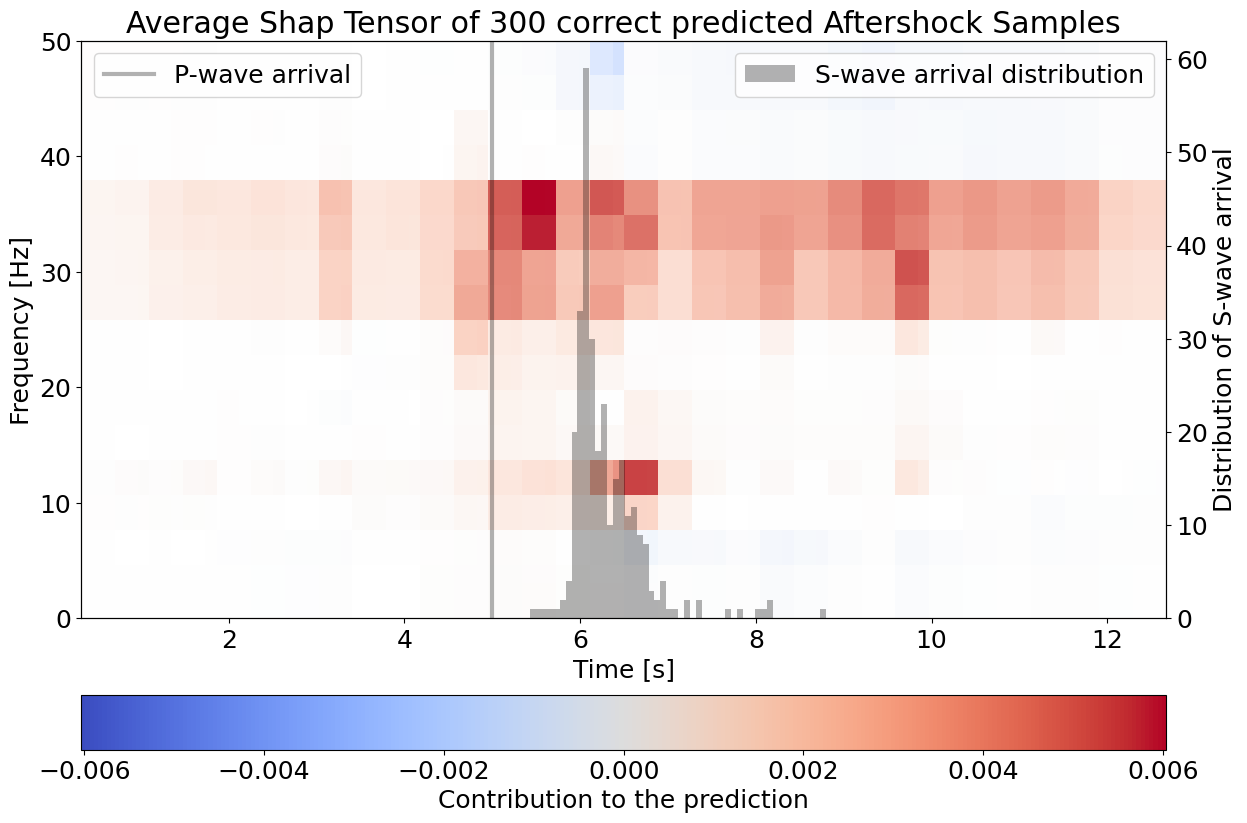

In [5]:
# Plot SHAP Tensor (P-fixed)

p_mean_pre = np.load(os.path.join(output_path, "avg_p_pre.npy"))
p_mean_post = np.load(os.path.join(output_path, "avg_p_post.npy"))
s_mean_pre = np.load(os.path.join(output_path, "avg_s_pre.npy"))
s_mean_post = np.load(os.path.join(output_path, "avg_s_post.npy"))

alpha_max = np.max([np.max(s_mean_pre), np.max(s_mean_post), np.max(p_mean_pre), np.max(p_mean_post)])
alpha_min = np.min([np.min(s_mean_pre), np.min(s_mean_post), np.min(p_mean_pre), np.min(p_mean_post)])


plot_mean_shap_p(p_mean_pre.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Foreshock Samples",
                 alpha_max = alpha_max,
                 alpha_min = alpha_min,
                 hist = 5 + foreshock_s_diff,
                 figsize=(14, 10))
plot_mean_shap_p(p_mean_post.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Aftershock Samples",
                 alpha_max = alpha_max,
                 alpha_min = alpha_min,
                 hist = 5 + aftershock_s_diff,
                 figsize=(14, 10))

In [ ]:
# SAVE PLOT IMAGES

plot_mean_shap_p(p_mean_pre.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Foreshock Samples",
                 alpha_max = alpha_max,
                 alpha_min = alpha_min,
                 hist = 5 + foreshock_s_diff,
                 figsize=(14, 10),
                 save_path=r"..\plots\mean_shap\p_fixed_mean_shap_pre.png")
plot_mean_shap_p(p_mean_post.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Aftershock Samples",
                 alpha_max = alpha_max,
                 alpha_min = alpha_min,
                 hist = 5 + aftershock_s_diff,
                 figsize=(14, 10),
                 save_path=r"..\plots\mean_shap\p_fixed_mean_shap_post.png")



#### Average S-fixed

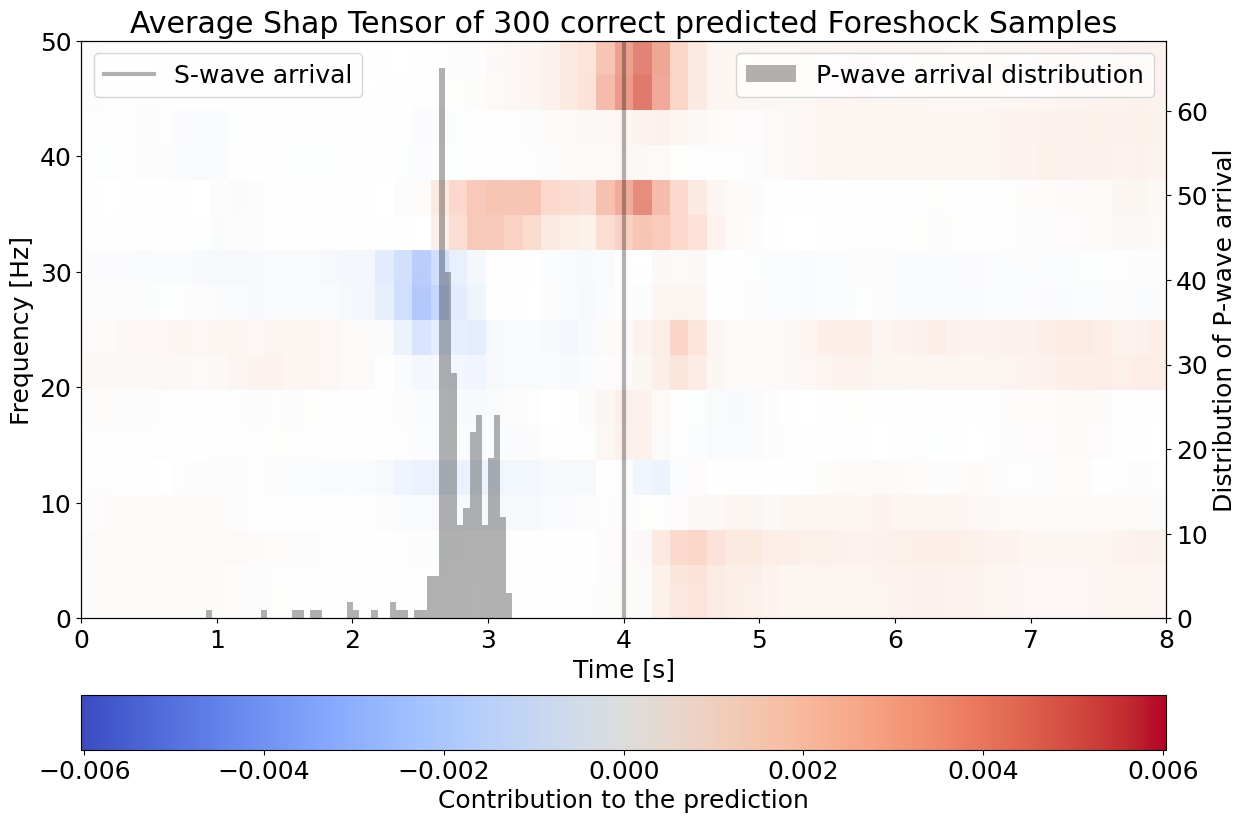

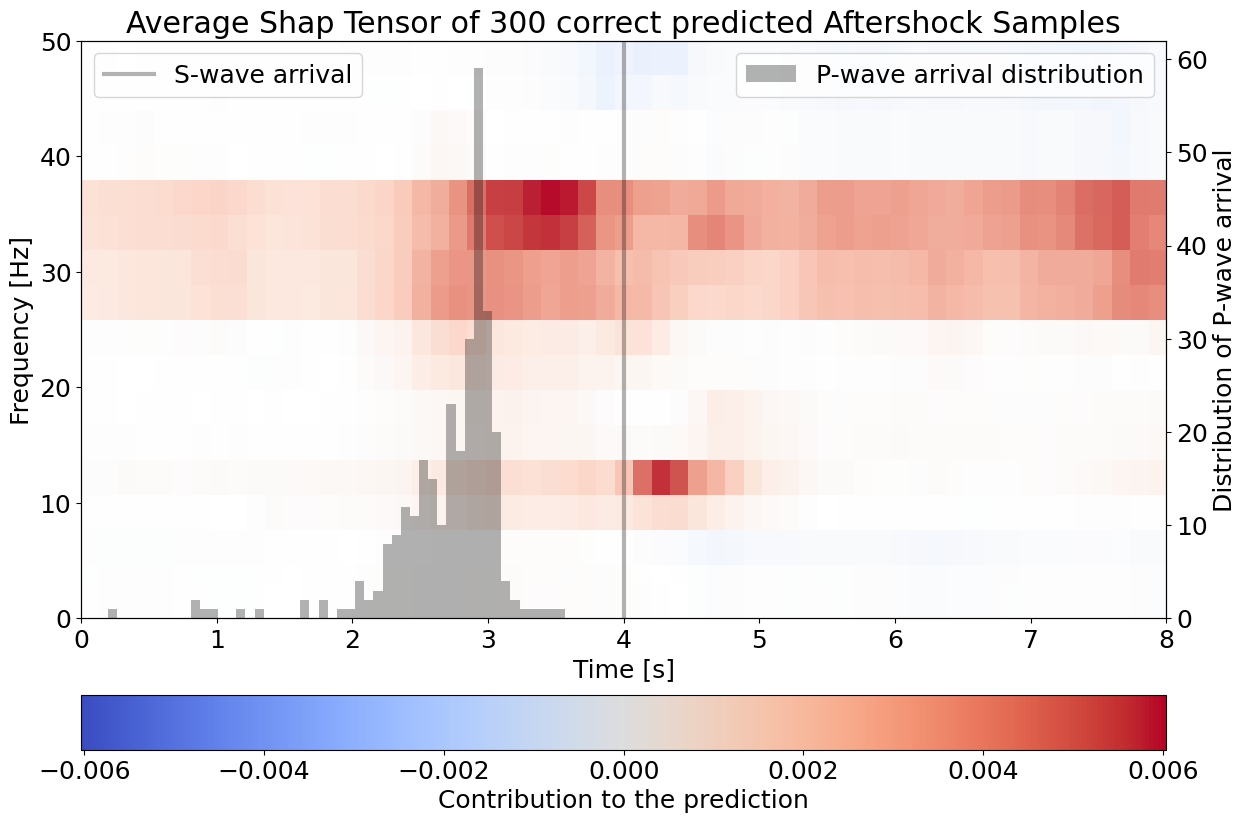

In [7]:
# Plot SHAP Tensor (P-fixed)
s_mean_pre = np.load(os.path.join(output_path, "avg_s_pre.npy"))
s_mean_post = np.load(os.path.join(output_path, "avg_s_post.npy"))
p_mean_post = np.load(os.path.join(output_path, "avg_p_post.npy"))
p_mean_pre = np.load(os.path.join(output_path, "avg_p_pre.npy"))

alpha_max = np.max([np.max(s_mean_pre), np.max(s_mean_post), np.max(p_mean_pre), np.max(p_mean_post)])
alpha_min = np.min([np.min(s_mean_pre), np.min(s_mean_post), np.min(p_mean_pre), np.min(p_mean_post)])

plot_mean_shap_s(s_mean_pre.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Foreshock Samples",
                 alpha_max = alpha_max,
                 alpha_min = alpha_min,
                 hist = 4 - foreshock_s_diff,
                 figsize=(14, 10))
plot_mean_shap_s(s_mean_post.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Aftershock Samples",
                 alpha_max=alpha_max,
                 alpha_min=alpha_min,
                 hist = 4 - aftershock_s_diff,
                 figsize=(14,10))

In [8]:
plot_mean_shap_s(s_mean_pre.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Foreshock Samples",
                 alpha_max = alpha_max,
                 alpha_min = alpha_min,
                 hist = 4 - foreshock_s_diff,
                 figsize=(14, 10),
                 save_path=r"..\plots\mean_shap\s_fixed_mean_shap_pre.png")
plot_mean_shap_s(s_mean_post.mean(axis=-1), 
                 ft, 
                 title = "Average Shap Tensor of 300 correct predicted Aftershock Samples",
                 alpha_max=alpha_max,
                 alpha_min=alpha_min,
                 hist = 4 - aftershock_s_diff,
                 figsize=(14, 10),
                 save_path=r"..\plots\mean_shap\s_fixed_mean_shap_post.png")

#### Temporal Evolution

In [6]:
# WEEKS STATS
first_week_pre = df[df["label"] == "pre"]["week"].values.min()
first_week_post = df[df["label"] == "post"]["week"].values.min()   
last_week_pre = df[df["label"] == "pre"]["week"].values.max()
last_week_post = df[df["label"] == "post"]["week"].values.max()

print("First week for Foreshocks: ", first_week_pre)
print("Last week for Foreshocks: ", last_week_pre)
print("Total weeks of Foreshocks: ", len(df[df["label"] == "pre"]["week"].unique()))
print()
print("First week for Aftershocks: ", first_week_post)
print("Last week for Aftershocks: ", last_week_post)
print("Total weeks of Foreshocks: ", len(df[df["label"] == "post"]["week"].unique()))
print()

for week in range(first_week_pre, last_week_post+1):
    print(f"Week {week}: ", len(df[df["week"] == week]))

First week for Foreshocks:  33
Last week for Foreshocks:  43
Total weeks of Foreshocks:  11

First week for Aftershocks:  44
Last week for Aftershocks:  51
Total weeks of Foreshocks:  8

Week 33:  1
Week 34:  444
Week 35:  600
Week 36:  387
Week 37:  360
Week 38:  479
Week 39:  338
Week 40:  309
Week 41:  308
Week 42:  318
Week 43:  88
Week 44:  352
Week 45:  151
Week 46:  388
Week 47:  379
Week 48:  304
Week 49:  299
Week 50:  283
Week 51:  38


##### Computing SHAP

In [7]:
first_week_pre = 34
first_week_post = 44  
last_week_pre = 43
last_week_post = 51

In [ ]:
# INTEGRATE MISSING WEEKS
week_traces = dict() # {week: [trace_name, trace_name, ...]}
input_folder = r"..\preprocessed_dset\spectrograms"
alredy_computed_pre = r"shap_tensors\foreshocks"
alredy_computed_post = r"shap_tensors\aftershocks"
target_image_folder = r"samples\temporal"
target_shap_folder = r"shap_tensors\temporal"
os.makedirs(target_image_folder, exist_ok=True)
os.makedirs(target_shap_folder, exist_ok=True)

pick_per_week = 10

for week in range(first_week_pre, last_week_pre+1):

    week_traces[week] = foreshock_df[foreshock_df["week"] == week]["trace_name"].values[:pick_per_week]
    for trace in week_traces[week]:
        already_path = os.path.join(alredy_computed_pre, trace + ".npy")
        target_shap_path = os.path.join(target_shap_folder, trace + ".npy")

        #os.system(f"copy {already_path} {target_shap_path}")

    week_diff_traces = pick_per_week - len(week_traces[week])

    new_traces = df[df["week"] == week]["trace_name"].values[:week_diff_traces]
    week_traces[week] = np.concatenate((week_traces[week], new_traces))
    for trace in new_traces:
        source_path = os.path.join(input_folder, trace + ".png")
        target_path = os.path.join(target_image_folder, trace + ".png")
        #os.system(f"copy {source_path} {target_path}")

    

for week in range(first_week_post, last_week_post+1):

    week_traces[week] = aftershock_df[aftershock_df["week"] == week]["trace_name"].values[:pick_per_week]
    for trace in week_traces[week]:
        already_path = os.path.join(alredy_computed_post, trace + ".npy")
        target_shap_path = os.path.join(target_shap_folder, trace + ".npy")

        #os.system(f"copy {already_path} {target_shap_path}")


    week_diff_traces = pick_per_week - len(week_traces[week])

    new_traces = df[df["week"] == week]["trace_name"].values[:week_diff_traces]
    week_traces[week] = np.concatenate((week_traces[week], new_traces))
    for trace in new_traces:
        source_path = os.path.join(input_folder, trace + ".png")
        target_path = os.path.join(target_image_folder, trace + ".png")
        #os.system(f"copy {source_path} {target_path}")


print("Already computed traces: ", len(os.listdir(target_shap_folder)))
#print("Images to compute: ", len(os.listdir(target_image_folder)))

Already computed traces:  180
Images to compute:  66


In [ ]:
# COMPUTE SHAP FOR NEW TRACES

dset_t = ExplainerDataset(data_path = os.path.join(shap_data_path, 'temporal'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_t = DataLoader(dset_t, batch_size=1, shuffle=False)

for sample in tqdm(dloader_t):
    compute_shap_tensor(model = model,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = target_shap_folder)
    
print("Total computed traces: ", len(os.listdir(target_shap_folder)))

##### Average SHAP per week

In [12]:
week_shap_average = dict() # {week: (shap_tensor, hist of s-wave arrival)}

for week in tqdm(week_traces):
    shap_tensors = []
    for trace in week_traces[week]:
        file_path = os.path.join(target_shap_folder, trace + ".npy")
        shap = np.load(file_path).squeeze(axis=0) # shape (33, 96, 3)
        shap_tensors.append(shap)
    
    shap_tensors = np.array(shap_tensors)
    shap_mean = shap_tensors.mean(axis=0)

    week_shap_average[week] = (shap_mean, df[df["trace_name"].isin(week_traces[week])]["p_s_diff_sec"].values)

100%|██████████| 18/18 [00:00<00:00, 193.52it/s]


In [14]:
alpha_max, alpha_min = -np.inf, np.inf
for week in week_shap_average:
    shap_tensor, _ = week_shap_average[week]
    alpha_max = max(alpha_max, shap_tensor.max())
    alpha_min = min(alpha_min, shap_tensor.min())

for week in week_shap_average:
    shap_tensor, hist = week_shap_average[week]
    plot_mean_shap_p(shap_tensor.mean(axis=-1), 
                     ft, 
                     title = f"Week {week} Shap Tensor ({'Aftershock' if week >= first_week_post else 'Foreshock'})",
                     alpha_max = alpha_max,
                     alpha_min = alpha_min,
                     hist = 5 + hist,
                     hist_bins = 5,
                     figsize=(10, 7),
                     save_path=f"..\plots\week_shap_analysis\week_{week}_mean_shap.png")

#### Misclassified Events

In [16]:
miss_shap = "shap_tensors\misclassified"
miss_samples = "samples\misclassified"
miss_df = pd.read_csv("samples\misclassified\model_output.csv")
os.makedirs("..\plots\misclassified", exist_ok=True)
df = pd.read_csv(meta_path)

for filename in os.listdir(miss_shap):
    if filename.endswith(".npy"):

        trace_name = filename.removesuffix(".npy")

        #open png spectrogram
        spectrogram_filename = os.path.join(miss_samples, trace_name + ".png")
        spectrogram = plt.imread(spectrogram_filename)

        row_df = df[df["trace_name"] == trace_name]
        row_miss = miss_df[miss_df["Trace Name"] == trace_name]

        s_arrival = row_df["p_s_diff_sec"].values[0]
        week = row_df["week"].values[0]
        day = row_df["trace_start_time"].values[0]
        label = row_df["label"].values[0]
        aftershock_value = row_miss["Aftershock_Value"].values[0]
        foreshock_value = row_miss["Foreshock_Value"].values[0]
        pred = "pre" if foreshock_value > aftershock_value else "post"
        output = np.array([foreshock_value, aftershock_value])
        smax = np.exp(output)/sum(np.exp(output))
        prob = smax[0] if pred == "pre" else smax[1]

        #print(prob)

        hdf5_path = os.path.join(wave_path, f"NRCA_{label}.hdf5")
        hdf = h5py.File(hdf5_path, "r")
        trace = hdf[trace_name][:]

        shap_tensor = np.load(os.path.join(miss_shap, filename)).squeeze(axis=0)
        aftershock_tensor = shap_tensor[:, :, :, 0] if pred == "post" else shap_tensor[:, :, :, 1]
        foreshock_tensor = shap_tensor[:, :, :, 1] if pred == "post" else shap_tensor[:, :, :, 0]
        aftershock_tensor, foreshock_tensor = aftershock_tensor.mean(axis=-1), foreshock_tensor.mean(axis=-1)

        title = f"Trace: {trace_name} - Label: {label}  - Prediction: {pred} (with ${{\\mathit{{I}}P}}$ = {prob:.2f}) \n Model Output: [Foreshock Value: {foreshock_value} - Aftershock Value: {aftershock_value}]\n Date: {day}  (Week {week})"


        subtitle2 = "SHAP Tensor for Aftershock Prediction"
        subtitle1 = "SHAP Tensor for Foreshock Prediction"

        plot_wf_shap_extended(shap_tensor1=foreshock_tensor, 
                              shap_tensor2=aftershock_tensor,
                              spectrogram=spectrogram,
                              waveform=trace,
                              title=title, 
                              subtitle1=subtitle1,
                              subtitle2=subtitle2,
                              ft = ft,
                              alt_wave= 5 + s_arrival,
                              figsize=(15, 10),
                              show = False,
                              save_path=os.path.join("..\plots\misclassified", f"{trace_name}_shap.png")
                              )

#### Examples

In [9]:
# Inference on example traces
trace_names = [tracename[:-4] for tracename in os.listdir("samples\examples")]
new_df = pd.read_csv(meta_path)
new_df = new_df[new_df["trace_name"].isin(trace_names)]
new_df.to_csv(os.path.join("samples\examples", "example_df.csv"), index=False)

for trace in trace_names:
    print(trace, new_df[new_df["trace_name"] == trace]["label"].values)

model.eval()

dset = SpectraDataset(data_path="samples\examples",
                            dataframe_path="samples\examples\example_df.csv",
                            transform = transform,
                            split="test",
                            colocated=False,
                            get_metadata=True)

dloader = DataLoader(dset, batch_size=1, shuffle=False)

output_dict = dict()

for sample in tqdm(dloader):

    image, label, trace_name, *_ = sample
    image = image.to(device)
    label = label.to(device)
    pred = model(image)
    output_dict[trace_name[0]] = pred.detach().cpu().numpy()[0]

print("Predictions: ", output_dict)

example_df []
NRCA.IV.100587679_EV ['post']
NRCA.IV.100617641_EV ['pre']


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

Predictions:  {'NRCA.IV.100587679_EV': array([-5.776631 ,  4.5262694], dtype=float32), 'NRCA.IV.100617641_EV': array([ 6.00428 , -4.506291], dtype=float32)}


In [10]:
ex_shap = "shap_tensors\examples"
ex_samples = "samples\examples"
os.makedirs("..\plots\examples", exist_ok=True)
df = pd.read_csv(meta_path)

vmin, vmax = np.inf, -np.inf

for filename in os.listdir(ex_shap):
    shap_tensor = np.load(os.path.join(ex_shap, filename)).squeeze(axis=0)
    vmin_temp, vmax_temp = np.min(shap_tensor), np.max(shap_tensor)
    vmin, vmax = min(vmin, vmin_temp), max(vmax, vmax_temp)


for filename in os.listdir(ex_shap):
    if filename.endswith(".npy"):

        trace_name = filename.removesuffix(".npy")

        #open png spectrogram
        spectrogram_filename = os.path.join(ex_samples, trace_name + ".png")
        spectrogram = plt.imread(spectrogram_filename)

        row_df = df[df["trace_name"] == trace_name]

        s_arrival = row_df["p_s_diff_sec"].values[0]
        week = row_df["week"].values[0]
        day = row_df["trace_start_time"].values[0]
        label = row_df["label"].values[0]
        aftershock_value = output_dict[trace_name][1]
        foreshock_value = output_dict[trace_name][0]
        pred = "pre" if foreshock_value > aftershock_value else "post"
        output = np.array([foreshock_value, aftershock_value])
        smax = np.exp(output)/sum(np.exp(output))
        prob = smax[0] if pred == "pre" else smax[1]

        #print(prob)

        hdf5_path = os.path.join(wave_path, f"NRCA_{label}.hdf5")
        hdf = h5py.File(hdf5_path, "r")
        trace = hdf[trace_name][:]

        shap_tensor = np.load(os.path.join(ex_shap, filename)).squeeze(axis=0)
        aftershock_tensor = shap_tensor[:, :, :, 0] if pred == "post" else shap_tensor[:, :, :, 1]
        foreshock_tensor = shap_tensor[:, :, :, 1] if pred == "post" else shap_tensor[:, :, :, 0]
        aftershock_tensor, foreshock_tensor = aftershock_tensor.mean(axis=-1), foreshock_tensor.mean(axis=-1)

        title = f"Trace: {trace_name} \n Model Output: [pre: {foreshock_value:.2f} - post: {aftershock_value:.2f}]\n Label: {label} - Prediction: {pred} (with ${{\\mathit{{I}}P}}$ = {prob:.2f})\n Date: {day[:-22]}  ({abs(week-43)} weeks {'after' if label == 'post' else 'before'})"


        subtitle2 = "SHAP Tensor for Aftershock Prediction"
        subtitle1 = "SHAP Tensor for Foreshock Prediction"

        plot_wf_shap_extended(shap_tensor1=foreshock_tensor, 
                              shap_tensor2=aftershock_tensor,
                              spectrogram=spectrogram,
                              waveform=trace,
                              alpha_min = vmin,
                              alpha_max = vmax,
                              title=title, 
                              h_space = .1,
                              ft = ft,
                              alt_wave= 5 + s_arrival,
                              figsize=(15, 18),
                              show = False,
                              overlap = False,
                              save_path=os.path.join("..\plots\examples", f"{trace_name}_shap.png")
                              )